# Anomaly Detection in Kepler Light Curves wiht Unsupervised Random Forest

This notebook contains code that allows the identification of anomalous light curves in Kepler Data. The method used is based on the Unsupervised Random Forest (URF) approach introduced for astronomy in Baron & Poznanski (2017). The code first extracts the relevant features, then runs the URF for a set of Kepler light curves in order to identify weird patterns in both the time and frenquency spaces, and then visualizes the findings.

In [1]:
%pylab inline
import numpy as np
import sklearn
#from sklearn.preprocessing import Imputer
import matplotlib.pyplot as plt

from sklearn import ensemble
import pandas as pd
import pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
periodograms=np.load('combined_features.npy')
print(np.shape(periodograms))

(2500, 6534)


In [3]:
f_interp_a = np.linspace(np.log10(0.011),np.log10(5.5),3000)
f_interp = 10.0**f_interp_a
frequencies1=f_interp

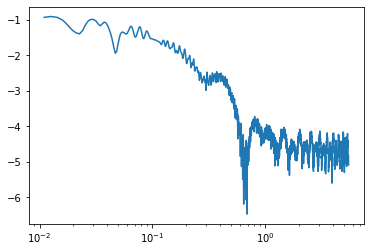

In [4]:
plt.plot(frequencies1,periodograms[0][3534:])
plt.xscale('log')

In [5]:
obj_ids = numpy.arange(len(periodograms))

In [6]:
def return_synthetic_data(X):
    """
    The function returns a matrix with the same dimensions as X but with synthetic data
    based on the marginal distributions of its featues
    """
    features = len(X[0])
    X_syn = numpy.zeros(X.shape)

    for i in range(features):
        obs_vec = X[:,i]
        syn_vec = numpy.random.choice(obs_vec, len(obs_vec)) # here we chose the synthetic data to match the marginal distribution of the real data
        X_syn[:,i] += syn_vec

    return X_syn

X_syn = return_synthetic_data(periodograms)

400
600


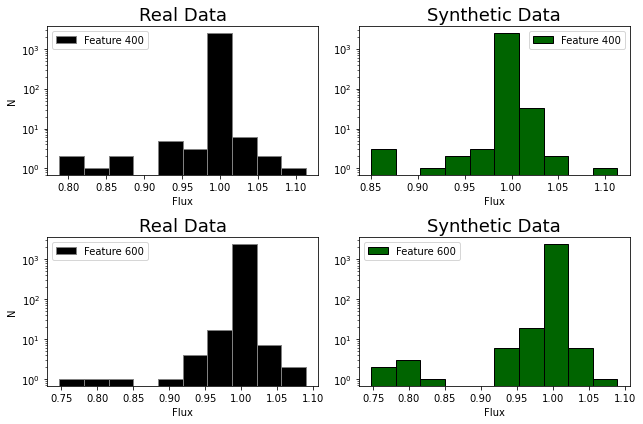

In [7]:
# plots synthetic features against real data checking correct distribution has been achieved.
plt.rcParams['figure.figsize'] = 8, 6
T=[400,600]
j=-1
plt.rcParams['figure.figsize'] = 9,6
for i in T:
    j=j+2
    print(i)
    plt.subplot(2,2,j)
    plt.title('Real Data',fontsize=18)
    plt.hist(periodograms[:, i] ,color="k",edgecolor='grey', label="Feature {}".format(i))
    plt.yscale('log')
    plt.legend(loc='best')
    plt.xlabel('Flux')
    plt.ylabel('N')
    
    plt.subplot(2,2,j+1)
    plt.title('Synthetic Data',fontsize=18)
    plt.hist(X_syn[:, i], color="darkgreen",edgecolor='black', label="Feature {}".format(i))
    plt.yscale('log')
    plt.xlabel('Flux')
    plt.legend(loc='best')
    
plt.tight_layout()

In [8]:
def merge_work_and_synthetic_samples(X, X_syn):
    """
    The function merges the data into one sample, giving the label "1" to the real data and label "2" to the synthetic data
    """
    # build the labels vector
    Y = numpy.ones(len(X))
    Y_syn = numpy.ones(len(X_syn)) * 2

    Y_total = numpy.concatenate((Y, Y_syn))
    X_total = numpy.concatenate((X, X_syn))
    return X_total, Y_total

X_total, Y_total = merge_work_and_synthetic_samples(periodograms, X_syn)
# declare an RF
N_TRAIN = 50 # number of trees in the forest
rand_f = ensemble.RandomForestClassifier(n_estimators=N_TRAIN, 
                                                 max_features='log2', max_depth=100,
                                                min_impurity_decrease=0.000001,min_samples_split=3,
                                                bootstrap=False,warm_start=True)
rand_f.fit(X_total, Y_total)

RandomForestClassifier(bootstrap=False, max_depth=100, max_features='log2',
                       min_impurity_decrease=1e-06, min_samples_split=3,
                       n_estimators=50, warm_start=True)

In [13]:
importances = rand_f.feature_importances_
std = np.std([rand_f.feature_importances_ for tree in rand_f.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking for the top 20 most important features
print("Feature ranking:")

for f in range(20):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 1685 (0.001522)
2. feature 1576 (0.001455)
3. feature 3649 (0.001428)
4. feature 766 (0.001401)
5. feature 1174 (0.001379)
6. feature 6030 (0.001351)
7. feature 2846 (0.001322)
8. feature 90 (0.001307)
9. feature 1240 (0.001306)
10. feature 6139 (0.001127)
11. feature 1442 (0.001105)
12. feature 4721 (0.001096)
13. feature 2808 (0.001074)
14. feature 6517 (0.001026)
15. feature 6165 (0.001024)
16. feature 3707 (0.001020)
17. feature 663 (0.001010)
18. feature 6382 (0.001008)
19. feature 3712 (0.001008)
20. feature 5083 (0.000992)


6534


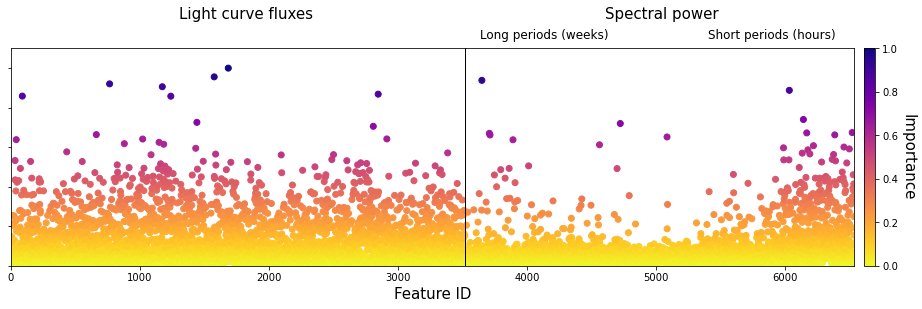

In [14]:
# Plot the features and their importances
importances = rand_f.feature_importances_
print(len(importances))
feats = arange(len(importances))
plt.rcParams['figure.figsize'] = 18, 4
#plt.axvline(x=337, color='r')
plt.axvline(x=3520, color='black',linewidth=1)
cm = plt.cm.get_cmap('plasma_r')
im = plt.scatter(feats,importances/np.max(importances),c=importances/np.max(importances),cmap=cm)
im.axes.yaxis.set_ticklabels([])
#xlim(0,637)
xlim(0,6534)
ylim(0,1.1)
plt.text(1300,1.25,'Light curve fluxes',size=15)
plt.text(4600,1.25,'Spectral power',size=15)
plt.text(5400,1.15,'Short periods (hours)',size=12)
plt.text(3634,1.15,'Long periods (weeks)',size=12)
#print(np.sum(importances[:3234]),np.sum(importances[3234:]))
plt.xlabel('Feature ID',size=15)
cbar = plt.colorbar(im,pad=0.01)
cbar.set_label('Importance',size=15,rotation=270,labelpad=17)

In [15]:
light_curves=2500
def build_similarity_matrix(rand_f, X):
    """
    The function builds the similarity matrix based on the feature matrix X for the results Y
    based on the random forest we've trained
    the matrix is normalised so that the biggest similarity is 1 and the lowest is 0

    This function counts only leaves in which the object is classified as a "real" object 
    it is also implemented to optimize running time, asumming one has enough running memory
    """

    # apply to get the leaf indices
    apply_mat = rand_f.apply(X)
    # find the predictions of the sample
    is_good_matrix = np.zeros(apply_mat.shape)
    for i, est in enumerate(rand_f.estimators_):
        d = est.predict_proba(X)[:, 0] == 1
        is_good_matrix[:, i] = d
    # mark leaves that make the wrong prediction as -1, in order to remove them from the distance measurement
    apply_mat[is_good_matrix == False] = -1
    
    leaf_pop=np.zeros((np.max(apply_mat[:,:]+1),N_TRAIN))
    #creates an array of each leaf population for all trees in RF
    for i in range(light_curves):
        for j in range(N_TRAIN):
            if apply_mat[i,j]!= -1:
                leaf_pop[apply_mat[i,j],j]+=1
                
    #used to normalize and wieght the results heavily towards trees that corretly identify objects as real or synthetic
    Normalization=np.sum(leaf_pop,axis=0)
    Norm_mean=np.mean(Normalization)
    #print('Normalization=',Normalization[20], Norm_mean)
    
    #Reduces each population by 1 to avoid self comparison.
    for i in range(leaf_pop.shape[0]):
        for j in range(N_TRAIN):
            if leaf_pop[i,j]!=0:
                leaf_pop[i,j]-=1
    
    #creates the similarity matrix by using the leaf populations rather then pair matching each light curve
    sim_vec=np.zeros(light_curves)
    for i in range(light_curves):
        for j in range(N_TRAIN):
            sim_vec[i]+=(leaf_pop[(apply_mat[i,j]),j]) #adds normalization here '/Normalization[j]'
    sim_vec/= float(len(sim_vec-1))*N_TRAIN
    return sim_vec
sim_mat = build_similarity_matrix(rand_f, periodograms)
print(sim_mat)
dis_mat=1-sim_mat
print(dis_mat)

[0.02228  0.470728 0.415736 ... 0.44008  0.128688 0.0336  ]
[0.97772  0.529272 0.584264 ... 0.55992  0.871312 0.9664  ]


Text(0.5, 0, 'Weirdness Score')

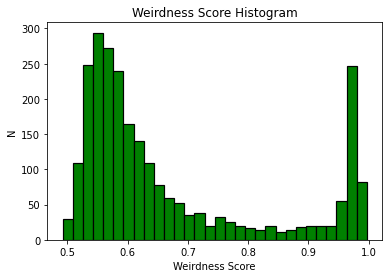

In [16]:
#Plot of Weirdness as a histogram for all objects.
sum_vec=dis_mat
plt.rcParams['figure.figsize'] = 6, 4
plt.title("Weirdness Score Histogram")
tmp = plt.hist(dis_mat, bins=30, color="g", edgecolor='black', linewidth=1.2)
plt.ylabel("N")
plt.xlabel("Weirdness Score")

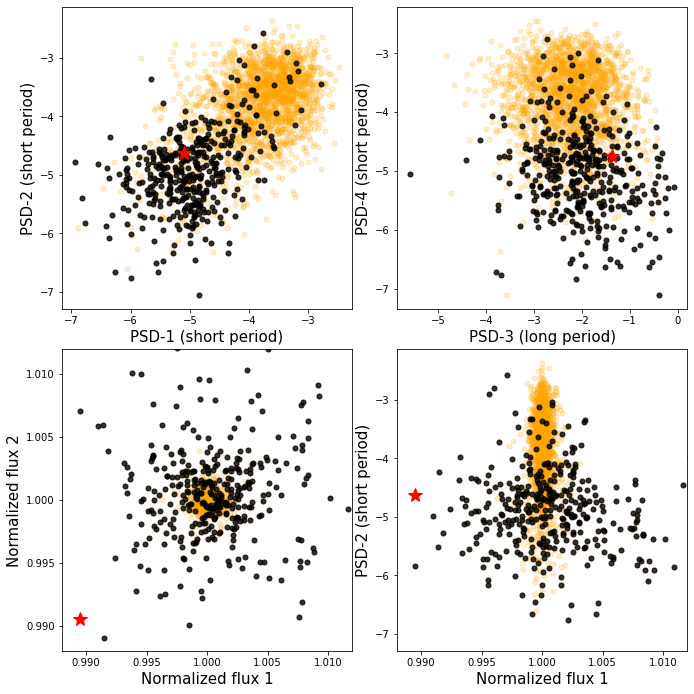

In [18]:
N_outliers = 400
sum_vec_outliers = numpy.sort(sum_vec)[::-1][:N_outliers]
obj_ids_outliers = obj_ids[numpy.argsort(sum_vec)][::-1][:N_outliers]

plt.rcParams['figure.figsize'] = 10,10
plt.subplot(2,2,1)
plt.plot(periodograms[:,6422], periodograms[:,6239], "ok", label="normal", markersize=5,alpha=0.2,color='orange')
plt.plot(periodograms[obj_ids_outliers, 6422], periodograms[obj_ids_outliers, 6239], "om", label="outliers", markersize=5,alpha=0.8,color='black')
plt.plot(periodograms[0,6422], periodograms[0,6239], marker='*', label="Tabby's star", markersize=15, color='red')
plt.xlabel("PSD-1 (short period)",size=15)
plt.ylabel("PSD-2 (short period)",size=15)
plt.subplot(2,2,2)
plt.plot(periodograms[:,3894], periodograms[:,6494], "ok", label="normal", markersize=5,alpha=0.2,color='orange')
plt.plot(periodograms[obj_ids_outliers, 3894], periodograms[obj_ids_outliers, 6494], "om", label="outliers", markersize=5,alpha=0.8,color='black')
plt.plot(periodograms[0,3894], periodograms[0,6494], marker='*', label="Tabby's star", markersize=15, color='red')
plt.xlabel("PSD-3 (long period)",size=15)
plt.ylabel("PSD-4 (short period)",size=15)
plt.subplot(2,2,3)
plt.plot(periodograms[:,2791], periodograms[:,1670], "ok", label="normal", markersize=5,alpha=0.2,color='orange')
plt.plot(periodograms[obj_ids_outliers, 2791], periodograms[obj_ids_outliers, 1670], "om", label="outliers", markersize=5,alpha=0.8,color='black')
plt.plot(periodograms[0,2791], periodograms[0,1670], marker='*', label="Tabby's star", markersize=15, color='red')
plt.xlim(0.988,1.012)
plt.ylim(0.988,1.012)
plt.xlabel("Normalized flux 1",size=15)
plt.ylabel("Normalized flux 2",size=15)
plt.subplot(2,2,4)
plt.plot(periodograms[:,2791], periodograms[:,6239], "ok", label="normal", markersize=5,alpha=0.2,color='orange')
plt.plot(periodograms[obj_ids_outliers, 2791], periodograms[obj_ids_outliers, 6239], "om", label="outliers", markersize=5,alpha=0.8,color='black')
plt.plot(periodograms[0,2791], periodograms[0,6239], marker='*', label="Tabby's star", markersize=15, color='red')
plt.xlim(0.988,1.012)
plt.xlabel("Normalized flux 1",size=15)
plt.ylabel("PSD-2 (short period)",size=15)
plt.tight_layout()    
plt.tight_layout(pad=2.0, w_pad=0.4, h_pad=0.4)

## Runs the URF Algorithm over N=10 repeats, using both Periodograms and Fluxes as features

In [19]:
# Run the algorithm N times, 
import time
obs_ids_outliers_all = []
obs_ids_outliers1_all = []
scores_more = []
scores_less = []
start=time.time()
Weirdness=np.zeros((2500,2))

for i in range(10): # N
    print(i,time.time()-start)
    X_syn = return_synthetic_data(periodograms)
    X_total, Y_total = merge_work_and_synthetic_samples(periodograms, X_syn)
    # declare an RF
    N_TRAIN = 50 # number of trees in the forest
    rand_f = ensemble.RandomForestClassifier(n_estimators=N_TRAIN, 
                                                 max_features='log2', max_depth=100,
                                                min_impurity_decrease=0.000001,min_samples_split=3,
                                                bootstrap=False,warm_start=True)
    rand_f.fit(X_total, Y_total)
    # Build sim_matrix
    sim_mat = build_similarity_matrix(rand_f, periodograms)
    dis_mat=1-sim_mat
    sum_vec=dis_mat
    N_outliers=100    
    sum_vec_outliers = np.sort(sum_vec)[::-1][:N_outliers]
    scores_more.append(sum_vec_outliers)
    obs_ids_outliers_all.append(obj_ids[np.argsort(sum_vec)][::-1][:N_outliers])
    sum_vec_outliers1 = np.sort(sum_vec)[:N_outliers]
    scores_less.append(sum_vec_outliers1)
    obs_ids_outliers1_all.append(obj_ids[np.argsort(sum_vec)][:N_outliers])
    for j in range(2500):
        Weirdness[j][0]+=dis_mat[j]
        if i==19:
            Weirdness[j][0]/=10
        Weirdness[j][1]=int(j)
end=time.time()-start

0 0.00022792816162109375
1 10.802181720733643
2 21.974166870117188
3 33.113173961639404
4 44.70029592514038
5 55.836045026779175
6 67.10914993286133
7 78.43537402153015
8 90.06038498878479
9 100.32896590232849


In [20]:
# Sorts objects by average weirdness over all repeats.
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
Weirdness=Weirdness[Weirdness[:,0].argsort()]
print(Weirdness[:20])
final_ids=(Weirdness[:,1])
final_ids = final_ids.astype(int)

[[5.926968 231.000000]
 [5.983504 890.000000]
 [5.994320 114.000000]
 [5.997368 1584.000000]
 [6.001824 960.000000]
 [6.005248 1975.000000]
 [6.005776 2201.000000]
 [6.022728 1680.000000]
 [6.028312 799.000000]
 [6.029496 654.000000]
 [6.033664 2399.000000]
 [6.050984 1945.000000]
 [6.052112 2064.000000]
 [6.052912 2073.000000]
 [6.055880 1605.000000]
 [6.057112 468.000000]
 [6.061752 575.000000]
 [6.064952 946.000000]
 [6.065520 2171.000000]
 [6.066376 11.000000]]


In [22]:
# Read the full light curves, Q16
lcvs = np.load('Kepler_Spike_Removal_Full_LCs.npy', encoding="latin1",allow_pickle=True)
Observables=np.load('HR_Observables.npy')

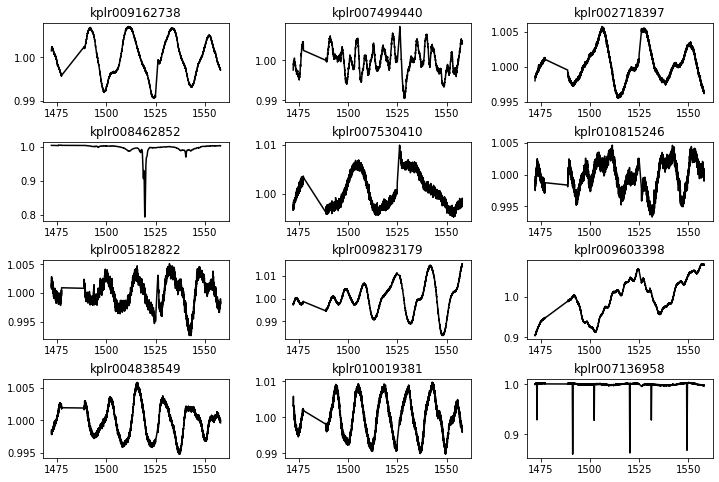

In [63]:
# Plot some weird LCs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.figure(figsize = (12,8))
gs1 = gridspec.GridSpec(4, 3)
gs1.update(wspace=0.3, hspace=0.5) # set the spacing between axes. 

ito = 2500-(12*17)
for i in range(ito-12,ito):
   # i = i + 1 # grid spec indexes from 0
    j = i%12
    ax1 = plt.subplot(gs1[j])
    plt.axis('on')
    #ax1.plot(lcvs[0][0],lcvs[int(final_ids[i])][1][:-1],color='black')
    ax1.plot(lcvs[final_ids[i]][0],lcvs[final_ids[i]][1],color='black')
    #ax1.set_ylim(0.999,1.0009)
    ax1.set_title(str(Observables[int(final_ids[i])][1]),size=12)
    ax1.set_xticks([1475,1500,1525,1550])